In [1]:
import numpy as np
import os
import re
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_eval_metric(mtcs, file): # 文件中共有多少次eval，以及最后一次eval的metric值
    i = 0
    metric = '\'acc\': '
    target_str = metric + '\d+.?\d+'
    number_str = '\d+.?\d+'
    for line in open(file,"r"):
        if metric in line:
            word = re.findall(target_str, line)[0]
            mtc = re.findall(number_str, word)[0]
            
            mtcs.append(mtc)
            i = i + 1
    return i, mtcs 

def insert_10(left, right):
    l = [left + 1]
    for i in range(left, right):
        if (i - left -1) % 10 == 0 and i != left + 1:
            l.append(i)
    l.append(right)
    return l

def merge_stack(lists):
    for i in range(len(lists)):
        merged_l = []
        l = lists[i]
        for a in l:
            for b in a:
                merged_l.append(b)
        lists[i] = merged_l
    return lists

def cut(x,y,upper_bound_acc):
    x = np.array(x) / 3600 # convert second to hour
    threshold = 0
    delete_y = [t for t in y if t > upper_bound_acc]
    if len(delete_y) > 0:
        if isinstance(y, list):
            threshold = y.index(delete_y[0])
        else:
            threshold = y.tolist().index(delete_y[0])
    else:
        threshold = len(y)
    y = y[:threshold]
    x = x[:threshold]
    return x,y
            
def sum_duration(depth, width, idx, tmp, time, type = "Dyna-A-Freeze", dataset = "20news"):
    if dataset == "20news":
        batch_num = 29
    if dataset == "agnews":
        batch_num = 30
    if dataset == "semeval":
        batch_num = 20
    if dataset == "onto":
        batch_num = 20
    if dataset == "20news" or dataset == "onto":
        latency_tx2_baseline = np.array([0.5325, 0.612, 0.696, 0.791, 0.883, 0.9713, 1.064, 1.156, 1.2465, 1.33, 1.419, 1.51, 1.7])
        latency_tx2_cached = np.array([0.02, 0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.90, 0.99, 1.08]) # msl = 256
    else:
        latency_tx2_baseline = np.array([0.5325, 0.612, 0.696, 0.791, 0.883, 0.9713, 1.064, 1.156, 1.2465, 1.33, 1.419, 1.51, 1.7]) / 4
        latency_tx2_cached = np.array([0.02, 0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.90, 0.99, 1.08]) / 4# msl = 64
    comm_bert = np.array([0.6, 7.7, 14.8, 21.9, 29.0, 36.0, 43.1, 50.2, 57.3, 64.4, 71.5, 78.6, 109.5]) * 32 / 8 # 这里面没有仅仅freeze embedding的数据
    adapter_para = 0.0125 * width / 8
    comm_adapter =np.array([0.02 + i * adapter_para for i in range(0,13)]) * 4
    
    if type == "BERT" or type == "Freeze":
        latency = latency_tx2_baseline
        comm = comm_bert * 2
    if type == "Q-Freeze": # 使用误差补偿的方法; Quantize Freeze; TODO:混合精度量化
        latency = latency_tx2_baseline
        comm = comm_bert * 2 / 8  # INT4 量化
    if type == "Quantize" : # 使用误差补偿的方法; Quantize Freeze; TODO:混合精度量化
        latency = latency_tx2_baseline
        comm = comm_bert * 2 / 4  # INT8 量化
    if type == "A-Freeze" or type == "Dyna-A-Freeze":
        latency = latency_tx2_cached 
        comm = comm_adapter * 2

    comm_tmp = comm[depth]
    duration = 0
    for i in range(0, idx - tmp):
        comp_tmp = latency[depth] * batch_num
        duration = duration + comp_tmp + comm_tmp
        # print(comp_tmp,comm_tmp)
    if len(time) > 0:
        time.append(duration + time[-1])
    else:
        time.append(duration)
    return time


depth-5-width-16 1.5788888888888895
depth-4-width-16 1.2666666666666666
depth-3-width-16 0.9544444444444449
depth-2-width-16 0.6422222222222219
depth-1-width-16 0.33
depth-0-width-16 0.16444444444444445
depth-11-width-8 6.493500000000003
depth-9-width-8 5.455555555555557
depth-7-width-8 4.251111111111115
depth-5-width-8 3.0466666666666686
depth-3-width-8 1.8422222222222235
depth-1-width-8 0.6377777777777783
depth-12-width-64 6.6184444444444415
depth-11-width-64 6.069055555555559
depth-9-width-64 6.512777777777779
depth-7-width-64 5.339999999999998
depth-5-width-64 3.824444444444448
depth-3-width-64 2.3088888888888905
depth-1-width-64 0.7933333333333339
depth-9-width-96 6.698611111111112
depth-7-width-96 5.96222222222222
depth-5-width-96 4.268888888888895
depth-3-width-96 2.5755555555555563
depth-1-width-96 0.8822222222222229
depth-12-width-128 8.16511111111112
depth-11-width-128 7.486833333333337
depth-9-width-128 6.130277777777777
depth-7-width-128 6.25522222222222
depth-5-width-128 4

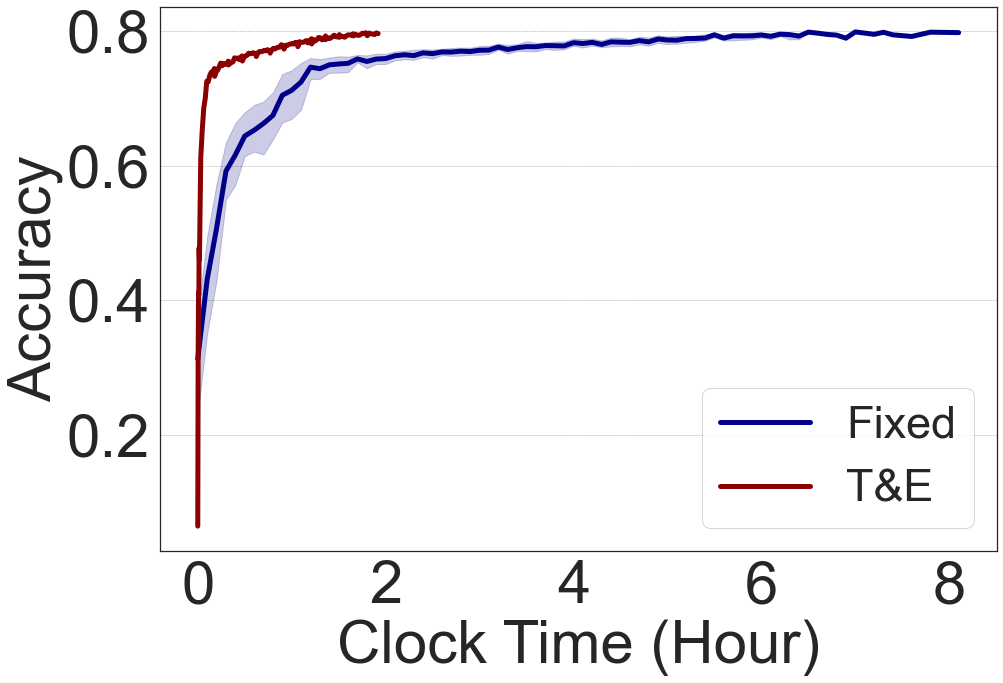

In [18]:
# 20news
# 20news
root_path = "/Users/cdq/Desktop/opensource/FedFinetuning/"
log_root_path = "data/nice_results/20news-Trail-0-60"
log_file_name = "fednlp_tc_deep_0.log"
file = os.path.join(root_path, log_root_path, log_file_name)


# depth, width, round, metric
dwrm = [[0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3], [8, 8, 8, 16, 16, 16, 24, 32, 32, 32, 40, 48, 48, 48, 56, 64, 64, 64, 64, 64], [-1, 79, 88, 180, 272, 364, 453, 539, 625, 711, 794, 875, 956, 1037, 1115, 1191, 1267, 1343, 1393, 1467], [0, '0.4681359532660648', '0.602761550716941', '0.7422995220392989', '0.7559745087626129', '0.7636749867233139', '0.7684545937334042', '0.7729686670207117', '0.7804036112586299', '0.7838555496548062', '0.7892989909718534', '0.7934147636749868', '0.7954062665958577', '0.7966011683483802', '0.7980616038236856', '0.8005841741901222', '0.8029739776951673', '0.8016463090812533', '0.8020446096654275', '0.8031067445565587']]


flag = ["init"]
trial_num = len(dwrm[0])
for i in range(trial_num-1):
    depth = dwrm[0]
    width = dwrm[1]
    if depth[i+1] > depth[i]: # deeper
        flag.append("deep")
    elif width[i+1] > width[i]: # wider
        flag.append("wide")
    else:
        flag.append("shallow")
dwrm.append(flag)

new_dwrm = [[],[],[],[]]
for i in range(1, trial_num):
    mtcs = [] # metric
    log_file_name = "fednlp_tc_" + dwrm[-1][i] + "_" + str(i-1) + ".log"
    file = os.path.join(root_path, log_root_path, log_file_name)
    count, mtcs = get_eval_metric(mtcs, file)
    new_dwrm[0].append([dwrm[0][i]] * count)
    new_dwrm[1].append([dwrm[1][i]] * count)
    new_dwrm[2].append(insert_10(dwrm[2][i-1], dwrm[2][i]))
    new_dwrm[3].append(mtcs) # mtcs是对的，其它不知道
# print(new_dwrm)

merged_new_dwrm = merge_stack(new_dwrm)

# from matplotlib.pyplot import MultipleLocator
# x_major_locator=MultipleLocator(2)
# y_major_locator=MultipleLocator(0.2)
# ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)

max_acc = 0.8
target_acc = 1
max_acc = max_acc * target_acc

fig, ax = plt.subplots()
ft = 60
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.xlabel("Clock Time (Hour)", fontsize=ft)
plt.ylabel("Accuracy", fontsize=ft)
plt.grid(color = 'k', axis="y", linestyle = '--', linewidth = 0.5, alpha=0.4)


from matplotlib.pyplot import MultipleLocator
x_major_locator=MultipleLocator(2)
y_major_locator=MultipleLocator(0.2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

sns.set(rc={'figure.figsize':(15,10)},style="white") # change default figure size


data_path = "/Users/cdq/Desktop/opensource/FedFinetuning/data/Baseline/20news_bert.csv"
raw_data = pd.read_csv(data_path,index_col=0)
column_name = raw_data.columns.values
multiple = 20
x = []
y = []

for col in column_name:
    time = []
    d = int(col.split("-")[1])
    w = int(col.split("-")[3])
    # if d == 2 and w == 16:
    #     continue
    data = raw_data.iloc[:,column_name.tolist().index(col)].dropna()
    round_idx = np.array(list(range(0,len(data)))) * multiple
    tmp = -1 * multiple # 记录最后一个访问的idx
    for idx in round_idx:
        time = sum_duration(d, w, idx, tmp, time, "Dyna-A-Freeze")
        tmp = idx
    time, data = cut(time, data, max_acc)
    for t in time:
        x.append(t)
    for d in data:
        y.append(d)
    # plt.scatter(np.array(time), data,s=100,c='blue',alpha=0.5) 
    # plt.plot(np.array(time), data, label = col)
    print(col,time[-1])

re_x = np.array(range(0,83))/10
re_x
# print(re_x)

for i in range(len(x)):
    for j in range(len(re_x)):
        if re_x[j] > x[i]:
            x[i] = re_x[j]-0.1
            break
        
data = np.column_stack((x, y))  # (630,2)

df = pd.DataFrame(data, columns=['time (h)', 'accuracy'])
sns.lineplot(x='time (h)', y='accuracy',data=df, ci = 100,label="Fixed", linewidth = 5,color="darkblue")
print(df)


time = []
data = new_dwrm
tmp = -1 # 记录最后一个访问的idx
y = [float(i) for i in data[3]]
for idx in data[2]:
    id = data[2].index(idx)
    d = data[0][id]
    w = data[1][id]
    time = sum_duration(d, w, idx, tmp, time, "Dyna-A-Freeze")
    tmp = idx

time, y = cut(time, y, max_acc)
data = np.column_stack((np.array(time), y))  # (630,2)
df = pd.DataFrame(data, columns=['time (h)', 'accuracy'])


sns.lineplot(x='time (h)', y='accuracy',data=df, ci = 100, color="darkred", linewidth = 5, label = "T&E")
# plt.plot(np.array(time), y, label = "Dyna-A-Freeze", color = "r", linewidth = 5)
print("Dyna-A-Freeze",time[-1])

plt.legend(fontsize=45,ncol = 1,frameon=True)
plt.savefig('../figs/eval-ablation-trial-20news.pdf', bbox_inches="tight")

Depth-0-Width-8 - Evaluation Accuracy 0.3856666666666649
Depth-1-Width-8 - Evaluation Accuracy 1.0492222222222132
Depth-2-Width-8 - Evaluation Accuracy 1.3159999999999994
Depth-4-Width-8 - Evaluation Accuracy 2.4583333333333504
Depth-6-Width-8 - Evaluation Accuracy 2.3739444444444553
Depth-8-Width-8 - Evaluation Accuracy 2.0140000000000056
Depth-10-Width-8 - Evaluation Accuracy 2.201111111111117
Depth-12-Width-8 - Evaluation Accuracy 2.497444444444451
Depth-0-Width-32 - Evaluation Accuracy 0.3856666666666649
Depth-1-Width-32 - Evaluation Accuracy 1.492555555555561
Depth-2-Width-32 - Evaluation Accuracy 1.9426666666666783
Depth-4-Width-32 - Evaluation Accuracy 3.7083333333333575
Depth-6-Width-32 - Evaluation Accuracy 3.6089444444444605
Depth-8-Width-32 - Evaluation Accuracy 3.074000000000009
Depth-10-Width-32 - Evaluation Accuracy 3.3677777777777864
Depth-12-Width-32- Evaluation Accuracy 3.827444444444454
Depth-0-Width-64 - Evaluation Accuracy 0.3856666666666649
Depth-1-Width-64 - Evalu

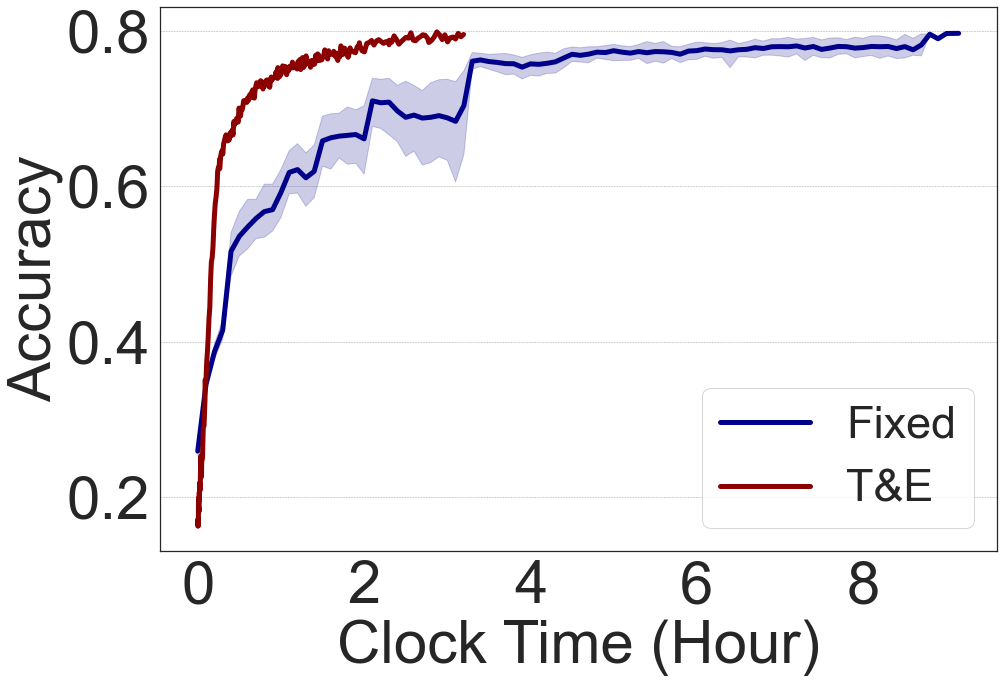

In [43]:
# semeval
root_path = "/Users/cdq/Desktop/opensource/FedFinetuning/"
log_root_path = "data/nice_results/semeval_2010_task8-Trail-1-90"
log_file_name = "semeval_2010_task8-depth-0-freq-90.log"
file = os.path.join(root_path, log_root_path, log_file_name)
ft = 60 # font size

# 
dwrm = [[1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12], [8, 16, 16, 16, 16, 16, 16, 16, 16, 24, 32, 32, 32, 32, 32, 40, 48, 48, 48, 56, 56, 56, 56], [-1, 206, 249, 434, 619, 804, 989, 1174, 1359, 1535, 1703, 1871, 1964, 2088, 2253, 2410, 2561, 2712, 2863, 3008, 3153, 3298, 3443],
[0, '0.2528524107471476', '0.3257269046742731', '0.6352594773647405', '0.6838424733161576', '0.7143908722856092', '0.7364740522635259', '0.7534044902465955', '0.7603974972396025', '0.7684946632315053', '0.7762237762237763', '0.7813765182186235', '0.7854251012145749', '0.7894736842105263', '0.7994111152005889', '0.805668016194332', '0.805668016194332', '0.8100846521899153', '0.8100846521899153', '0.8141332351858668', '0.8185498711814502', '0.8181818181818182', '0.819654030180346']]


flag = ["init"]
trial_num = len(dwrm[0])
for i in range(trial_num-1):
    depth = dwrm[0]
    width = dwrm[1]
    if depth[i+1] > depth[i]: # deeper
        flag.append("deep")
    elif width[i+1] > width[i]: # wider
        flag.append("wide")
    else:
        flag.append("shallow")
dwrm.append(flag)

new_dwrm = [[],[],[],[]]
for i in range(1, trial_num):
    mtcs = [] # metric
    log_file_name = "fednlp_tc_" + dwrm[-1][i] + "_" + str(i-1) + ".log"
    file = os.path.join(root_path, log_root_path, log_file_name)
    count, mtcs = get_eval_metric(mtcs, file)
    new_dwrm[0].append([dwrm[0][i]] * count)
    new_dwrm[1].append([dwrm[1][i]] * count)
    new_dwrm[2].append(insert_10(dwrm[2][i-1], dwrm[2][i]))
    new_dwrm[3].append(mtcs) # mtcs是对的，其它不知道
# print(new_dwrm)

merged_new_dwrm = merge_stack(new_dwrm)

ft = 60


# from matplotlib.pyplot import MultipleLocator
# x_major_locator=MultipleLocator(2)
# y_major_locator=MultipleLocator(0.2)
# ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)

max_acc = 0.8
target_acc = 1
max_acc = max_acc * target_acc

fig, ax = plt.subplots()
ft = 60
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.xlabel("Clock Time (Hour)", fontsize=ft)
plt.ylabel("Accuracy", fontsize=ft)
plt.grid(color = 'k', axis="y", linestyle = '--', linewidth = 0.5, alpha=0.4)


from matplotlib.pyplot import MultipleLocator
x_major_locator=MultipleLocator(2)
y_major_locator=MultipleLocator(0.2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

sns.set(rc={'figure.figsize':(15,10)},style="white") # change default figure size


data_path = "/Users/cdq/Desktop/opensource/FedFinetuning/data/Baseline/semeval-handmake.csv"
raw_data = pd.read_csv(data_path,index_col=0)
column_name = raw_data.columns.values
multiple = 10
x = []
y = []

for col in column_name:
    time = []
    d = int(col.split("-")[1])
    w = int(col.split("-")[3])
    data = raw_data.iloc[:,column_name.tolist().index(col)].dropna().tolist()
    round_idx = np.array(list(range(0,len(data)))) * multiple
    tmp = -1 * multiple # 记录最后一个访问的idx
    for idx in round_idx:
        time = sum_duration(d, w, idx, tmp, time, "Dyna-A-Freeze","semeval")
        tmp = idx
    # print(data)
    time, data = cut(time, data, 0.8)
    for i in range(len(data)):
        if data[i] <= max_acc:
            x.append(time[i])
            y.append(data[i])
        else:
            break
    # plt.scatter(np.array(time), data,s=100,c='blue',alpha=0.5) 
    # plt.plot(np.array(time), data, label = col)
    print(col,time[-1])

re_x = np.array(range(0,92))/ 10

# 将离散点聚合到固定点位上
for i in range(len(x)):
    for j in range(len(re_x)):
        if re_x[j] > x[i]:
            x[i] = re_x[j]-0.1
            break
        
data = np.column_stack((x, y))  # (630,2)
# print(y)
df = pd.DataFrame(data, columns=['time (h)', 'accuracy'])
sns.lineplot(x='time (h)', y='accuracy',data=df, ci = 100,label="Fixed", linewidth = 5,color="darkblue")



time = []
data = new_dwrm
tmp = -1 # 记录最后一个访问的idx
y = [float(i) for i in data[3]]
for idx in data[2]:
    id = data[2].index(idx)
    d = data[0][id]
    w = data[1][id]
    time = sum_duration(d, w, idx, tmp, time, "Dyna-A-Freeze","semeval")
    tmp = idx
    
time = np.array(time)
time, y = cut(time, y, max_acc)
data = np.column_stack((np.array(time), y))  # (630,2)
df = pd.DataFrame(data, columns=['time (h)', 'accuracy'])


sns.lineplot(x='time (h)', y='accuracy',data=df, ci = 100, color="darkred", linewidth = 5, label = "T&E")
# plt.plot(np.array(time), y, label = "Dyna-A-Freeze", color = "r", linewidth = 5)
print("Dyna-A-Freeze",time[-1])

plt.legend(fontsize=45,ncol = 1,frameon=True)
plt.savefig('../figs/eval-ablation-trial-semeval.pdf', bbox_inches="tight")

[0.0, 0.1, 0.19999999999999998, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0, 1.0999999999999999, 1.2, 1.2999999999999998, 1.4, 1.5, 1.5999999999999999, 1.7, 1.7999999999999998, 1.9, 2.0, 2.1, 2.1999999999999997, 2.3, 2.4, 2.5, 2.6, 2.6999999999999997, 2.8, 2.9, 3.0, 3.1, 3.1999999999999997, 3.3, 3.4, 3.5, 3.6, 3.6999999999999997, 3.8, 3.9, 3.9999999999999996, 4.1000000000000005, 4.2, 4.300000000000001, 4.4, 4.5, 4.6000000000000005, 4.7, 4.800000000000001, 4.9, 5.0, 5.1000000000000005, 5.2, 5.300000000000001, 5.4, 5.5, 5.6000000000000005, 5.7, 5.800000000000001, 5.9, 6.0, 6.1000000000000005, 6.2, 6.300000000000001, 6.4, 6.5, 6.6000000000000005, 6.7, 6.800000000000001, 6.9, 7.0, 7.2, 7.300000000000001, 7.4, 7.6000000000000005, 7.800000000000001, 8.16511111111112]
Dyna-A-Freeze 1.9206833333333364


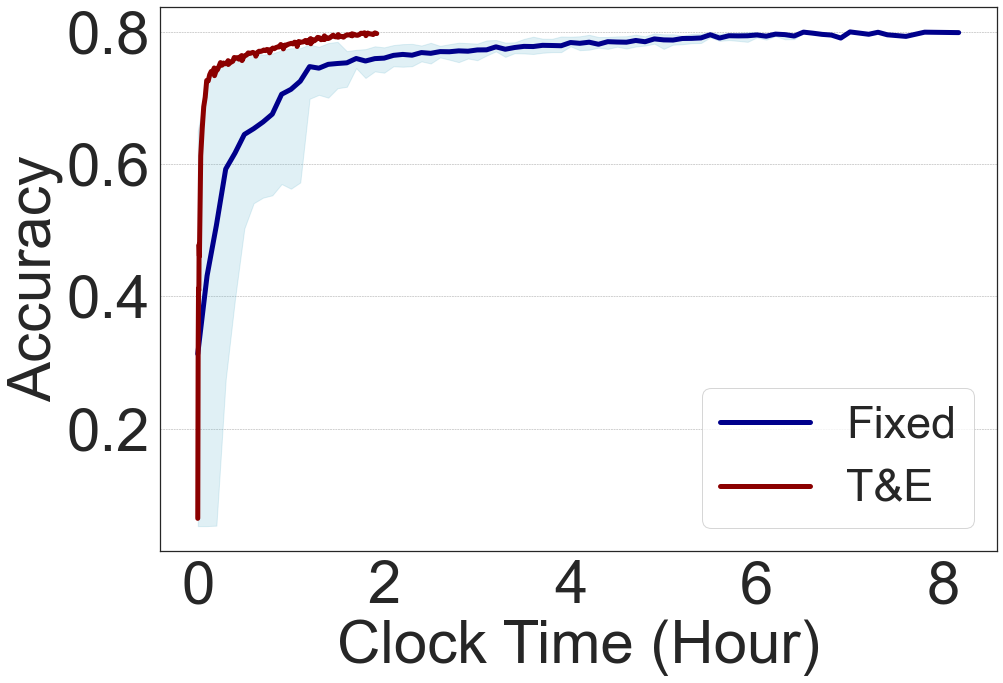

In [117]:
# 20news
# 20news
root_path = "/Users/cdq/Desktop/opensource/FedFinetuning/"
log_root_path = "data/nice_results/20news-Trail-0-60"
log_file_name = "fednlp_tc_deep_0.log"
file = os.path.join(root_path, log_root_path, log_file_name)


# depth, width, round, metric
dwrm = [[0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3], [8, 8, 8, 16, 16, 16, 24, 32, 32, 32, 40, 48, 48, 48, 56, 64, 64, 64, 64, 64], [-1, 79, 88, 180, 272, 364, 453, 539, 625, 711, 794, 875, 956, 1037, 1115, 1191, 1267, 1343, 1393, 1467], [0, '0.4681359532660648', '0.602761550716941', '0.7422995220392989', '0.7559745087626129', '0.7636749867233139', '0.7684545937334042', '0.7729686670207117', '0.7804036112586299', '0.7838555496548062', '0.7892989909718534', '0.7934147636749868', '0.7954062665958577', '0.7966011683483802', '0.7980616038236856', '0.8005841741901222', '0.8029739776951673', '0.8016463090812533', '0.8020446096654275', '0.8031067445565587']]


flag = ["init"]
trial_num = len(dwrm[0])
for i in range(trial_num-1):
    depth = dwrm[0]
    width = dwrm[1]
    if depth[i+1] > depth[i]: # deeper
        flag.append("deep")
    elif width[i+1] > width[i]: # wider
        flag.append("wide")
    else:
        flag.append("shallow")
dwrm.append(flag)

new_dwrm = [[],[],[],[]]
for i in range(1, trial_num):
    mtcs = [] # metric
    log_file_name = "fednlp_tc_" + dwrm[-1][i] + "_" + str(i-1) + ".log"
    file = os.path.join(root_path, log_root_path, log_file_name)
    count, mtcs = get_eval_metric(mtcs, file)
    new_dwrm[0].append([dwrm[0][i]] * count)
    new_dwrm[1].append([dwrm[1][i]] * count)
    new_dwrm[2].append(insert_10(dwrm[2][i-1], dwrm[2][i]))
    new_dwrm[3].append(mtcs) # mtcs是对的，其它不知道
# print(new_dwrm)

merged_new_dwrm = merge_stack(new_dwrm)

# from matplotlib.pyplot import MultipleLocator
# x_major_locator=MultipleLocator(2)
# y_major_locator=MultipleLocator(0.2)
# ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)

max_acc = 0.8
target_acc = 1
max_acc = max_acc * target_acc

fig, ax = plt.subplots()
ft = 60
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.xlabel("Clock Time (Hour)", fontsize=ft)
plt.ylabel("Accuracy", fontsize=ft)
plt.grid(color = 'k', axis="y", linestyle = '--', linewidth = 0.5, alpha=0.4)


from matplotlib.pyplot import MultipleLocator
x_major_locator=MultipleLocator(2)
y_major_locator=MultipleLocator(0.2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

sns.set(rc={'figure.figsize':(15,10)},style="white") # change default figure size


data_path = "/Users/cdq/Desktop/opensource/FedFinetuning/data/Baseline/20news_bert.csv"
raw_data = pd.read_csv(data_path,index_col=0)
column_name = raw_data.columns.values
multiple = 20
x = []
y = []

for col in column_name:
    time = []
    d = int(col.split("-")[1])
    w = int(col.split("-")[3])
    # if d == 2 and w == 16:
    #     continue
    data = raw_data.iloc[:,column_name.tolist().index(col)].dropna()
    round_idx = np.array(list(range(0,len(data)))) * multiple
    tmp = -1 * multiple # 记录最后一个访问的idx
    for idx in round_idx:
        time = sum_duration(d, w, idx, tmp, time, "Dyna-A-Freeze")
        tmp = idx
    time, data = cut(time, data, max_acc)
    for t in time:
        x.append(t)
    for d in data:
        y.append(d)
    # plt.scatter(np.array(time), data,s=100,c='blue',alpha=0.5) 
    # plt.plot(np.array(time), data, label = col)
    # print(col,time[-1])

re_x = np.array(range(0,82))/10
# print(re_x)

for i in range(len(x)):
    for j in range(len(re_x)):
        if re_x[j] > x[i]:
            x[i] = re_x[j]-0.1
            break
        
data = np.column_stack((x, y))  # (630,2)
x = list(set(x))
x = sorted(x)
# print(x)
df = pd.DataFrame(data, columns=['time (h)', 'accuracy'])
y_group = df.groupby("time (h)")
y_mean = y_group.mean()["accuracy"]
y_max = y_group.max()["accuracy"]
y_min = y_group.min()["accuracy"]

plt.plot(x, y_mean, color='darkblue',  linewidth = 5, label='Fixed')
# plt.plot(time, sin_waves, 'b-', label='ideal')
plt.fill_between(x, y_min, y_max, color='c', alpha=0.2)


time = []
data = new_dwrm
tmp = -1 # 记录最后一个访问的idx
y = [float(i) for i in data[3]]
for idx in data[2]:
    id = data[2].index(idx)
    d = data[0][id]
    w = data[1][id]
    time = sum_duration(d, w, idx, tmp, time, "Dyna-A-Freeze")
    tmp = idx

time, y = cut(time, y, max_acc)
data = np.column_stack((np.array(time), y))  # (630,2)
df = pd.DataFrame(data, columns=['time (h)', 'accuracy'])


sns.lineplot(x='time (h)', y='accuracy',data=df, ci = 100, color="darkred", linewidth = 5, label = "T&E")
# plt.plot(np.array(time), y, label = "Dyna-A-Freeze", color = "r", linewidth = 5)
print("Dyna-A-Freeze",time[-1])

plt.legend(fontsize=45,ncol = 1,frameon=True)
plt.savefig('../figs/eval-ablation-trial-20news.pdf', bbox_inches="tight")


Depth-0-Width-8 - Evaluation Accuracy 0.3856666666666649
Depth-1-Width-8 - Evaluation Accuracy 1.0492222222222132
Depth-2-Width-8 - Evaluation Accuracy 1.3159999999999994
Depth-4-Width-8 - Evaluation Accuracy 2.4583333333333504
Depth-6-Width-8 - Evaluation Accuracy 2.3739444444444553
Depth-8-Width-8 - Evaluation Accuracy 2.0140000000000056
Depth-10-Width-8 - Evaluation Accuracy 2.201111111111117
Depth-12-Width-8 - Evaluation Accuracy 2.497444444444451
Depth-0-Width-32 - Evaluation Accuracy 0.3856666666666649
Depth-1-Width-32 - Evaluation Accuracy 1.492555555555561
Depth-2-Width-32 - Evaluation Accuracy 1.9426666666666783
Depth-4-Width-32 - Evaluation Accuracy 3.7083333333333575
Depth-6-Width-32 - Evaluation Accuracy 3.6089444444444605
Depth-8-Width-32 - Evaluation Accuracy 3.074000000000009
Depth-10-Width-32 - Evaluation Accuracy 3.3677777777777864
Depth-12-Width-32- Evaluation Accuracy 3.827444444444454
Depth-0-Width-64 - Evaluation Accuracy 0.3856666666666649
Depth-1-Width-64 - Evalu

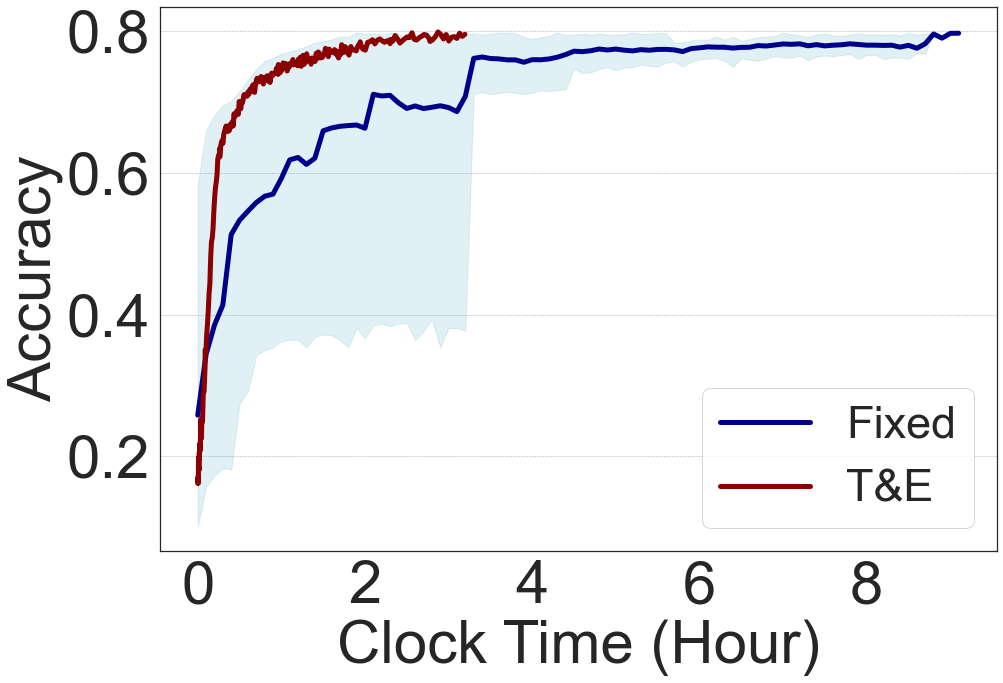

In [72]:
# semeval
root_path = "/Users/cdq/Desktop/opensource/FedFinetuning/"
log_root_path = "data/nice_results/semeval_2010_task8-Trail-1-90"
log_file_name = "semeval_2010_task8-depth-0-freq-90.log"
file = os.path.join(root_path, log_root_path, log_file_name)
ft = 60 # font size

# 
dwrm = [[1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12], [8, 16, 16, 16, 16, 16, 16, 16, 16, 24, 32, 32, 32, 32, 32, 40, 48, 48, 48, 56, 56, 56, 56], [-1, 206, 249, 434, 619, 804, 989, 1174, 1359, 1535, 1703, 1871, 1964, 2088, 2253, 2410, 2561, 2712, 2863, 3008, 3153, 3298, 3443],
[0, '0.2528524107471476', '0.3257269046742731', '0.6352594773647405', '0.6838424733161576', '0.7143908722856092', '0.7364740522635259', '0.7534044902465955', '0.7603974972396025', '0.7684946632315053', '0.7762237762237763', '0.7813765182186235', '0.7854251012145749', '0.7894736842105263', '0.7994111152005889', '0.805668016194332', '0.805668016194332', '0.8100846521899153', '0.8100846521899153', '0.8141332351858668', '0.8185498711814502', '0.8181818181818182', '0.819654030180346']]


flag = ["init"]
trial_num = len(dwrm[0])
for i in range(trial_num-1):
    depth = dwrm[0]
    width = dwrm[1]
    if depth[i+1] > depth[i]: # deeper
        flag.append("deep")
    elif width[i+1] > width[i]: # wider
        flag.append("wide")
    else:
        flag.append("shallow")
dwrm.append(flag)

new_dwrm = [[],[],[],[]]
for i in range(1, trial_num):
    mtcs = [] # metric
    log_file_name = "fednlp_tc_" + dwrm[-1][i] + "_" + str(i-1) + ".log"
    file = os.path.join(root_path, log_root_path, log_file_name)
    count, mtcs = get_eval_metric(mtcs, file)
    new_dwrm[0].append([dwrm[0][i]] * count)
    new_dwrm[1].append([dwrm[1][i]] * count)
    new_dwrm[2].append(insert_10(dwrm[2][i-1], dwrm[2][i]))
    new_dwrm[3].append(mtcs) # mtcs是对的，其它不知道
# print(new_dwrm)

merged_new_dwrm = merge_stack(new_dwrm)

ft = 60


# from matplotlib.pyplot import MultipleLocator
# x_major_locator=MultipleLocator(2)
# y_major_locator=MultipleLocator(0.2)
# ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)

max_acc = 0.8
target_acc = 1
max_acc = max_acc * target_acc

fig, ax = plt.subplots(figsize=(15,10))
ft = 60
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.xlabel("Clock Time (Hour)", fontsize=ft)
plt.ylabel("Accuracy", fontsize=ft)
plt.grid(color = 'k', axis="y", linestyle = '--', linewidth = 0.5, alpha=0.4)


from matplotlib.pyplot import MultipleLocator
x_major_locator=MultipleLocator(2)
y_major_locator=MultipleLocator(0.2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)


data_path = "/Users/cdq/Desktop/opensource/FedFinetuning/data/Baseline/semeval-handmake.csv"
raw_data = pd.read_csv(data_path,index_col=0)
column_name = raw_data.columns.values
multiple = 10
x = []
y = []

for col in column_name:
    time = []
    d = int(col.split("-")[1])
    w = int(col.split("-")[3])
    data = raw_data.iloc[:,column_name.tolist().index(col)].dropna().tolist()
    round_idx = np.array(list(range(0,len(data)))) * multiple
    tmp = -1 * multiple # 记录最后一个访问的idx
    for idx in round_idx:
        time = sum_duration(d, w, idx, tmp, time, "Dyna-A-Freeze","semeval")
        tmp = idx
    # print(data)
    time, data = cut(time, data, 0.8)
    for i in range(len(data)):
        if data[i] <= max_acc:
            x.append(time[i])
            y.append(data[i])
        else:
            break
    # plt.scatter(np.array(time), data,s=100,c='blue',alpha=0.5) 
    # plt.plot(np.array(time), data, label = col)
    print(col,time[-1])

re_x = np.array(range(0,92))/ 10

# 将离散点聚合到固定点位上
for i in range(len(x)):
    for j in range(len(re_x)):
        if re_x[j] > x[i]:
            x[i] = re_x[j]-0.1
            break


data = np.column_stack((x, y))  # (630,2)

df = pd.DataFrame(data, columns=['time (h)', 'accuracy'])
y_group = df.groupby("time (h)")
y_mean = y_group.mean()["accuracy"]
y_max = y_group.max()["accuracy"]
y_min = y_group.min()["accuracy"]
plt.plot(re_x, y_mean, color='darkblue',  linewidth = 5, label='Fixed')
# plt.plot(time, sin_waves, 'b-', label='ideal')
plt.fill_between(re_x, y_min, y_max, color='c', alpha=0.2)



time = []
data = new_dwrm
tmp = -1 # 记录最后一个访问的idx
y = [float(i) for i in data[3]]
for idx in data[2]:
    id = data[2].index(idx)
    d = data[0][id]
    w = data[1][id]
    time = sum_duration(d, w, idx, tmp, time, "Dyna-A-Freeze","semeval")
    tmp = idx
    
time = np.array(time)
time, y = cut(time, y, max_acc)

plt.plot(time, y, color='darkred', linewidth = 5, label = "T&E")

print("Dyna-A-Freeze",time[-1])

plt.legend(fontsize=45,ncol = 1,frameon=True)
plt.savefig('../figs/eval-ablation-trial-semeval.pdf', bbox_inches="tight")

In [61]:
df6.groupby("time (h)").mean()

,accuracy
time (h),
0.000000,0.258633
0.100000,0.345245
0.200000,0.386405
0.300000,0.414536
0.400000,0.516382
...,...
8.700000,0.782665
8.800000,0.796467
8.900000,0.790578


In [50]:
# sin_waves = np.expand_dims(sin_waves, axis=-1)
sin_waves.shape

(63, 1)

In [49]:
noise = np.random.random((time.size, 10)) - 0.5
print('noise shape: ', noise.shape)  # (63, 10)
noise

noise shape:  (63, 10)


array([[ 4.58850142e-01,  1.64414444e-01,  4.23518524e-01,
        -2.73289559e-01,  1.54427331e-01, -2.35333875e-01,
         1.59680378e-01, -4.95751278e-01,  4.11967798e-01,
        -1.76736916e-01],
       [ 1.52825486e-02,  4.39847148e-01, -1.09613234e-01,
        -3.37420320e-01,  2.48843605e-01,  4.17215162e-01,
         3.38706524e-01, -3.15801766e-01,  2.23182638e-01,
         3.97213644e-02],
       [-1.45954518e-01,  5.43790825e-02,  2.84886419e-01,
        -4.06152855e-02, -1.49841230e-01,  1.01384575e-01,
         3.76906058e-01,  3.96747545e-01, -1.35442488e-01,
        -3.62144774e-02],
       [ 1.80498982e-01, -4.95125496e-01, -3.38426892e-02,
        -3.56647937e-01,  1.11834710e-01,  4.15301354e-01,
         2.42667746e-01, -1.27642279e-01, -7.70978697e-02,
        -4.97426077e-01],
       [-3.33408825e-02, -2.62005675e-01, -7.25018579e-02,
        -2.79719769e-01, -3.01027169e-01, -2.29181342e-01,
        -7.31812911e-02, -2.77172155e-01, -1.86460658e-01,
        -3.

In [51]:
data = sin_waves + noise

In [52]:
data

array([[ 4.58850142e-01,  1.64414444e-01,  4.23518524e-01,
        -2.73289559e-01,  1.54427331e-01, -2.35333875e-01,
         1.59680378e-01, -4.95751278e-01,  4.11967798e-01,
        -1.76736916e-01],
       [ 1.15115965e-01,  5.39680564e-01, -9.77981777e-03,
        -2.37586904e-01,  3.48677022e-01,  5.17048579e-01,
         4.38539940e-01, -2.15968349e-01,  3.23016055e-01,
         1.39554781e-01],
       [ 5.27148127e-02,  2.53048413e-01,  4.83555750e-01,
         1.58054045e-01,  4.88281012e-02,  3.00053905e-01,
         5.75575388e-01,  5.95416876e-01,  6.32268431e-02,
         1.62454853e-01],
       [ 4.76019189e-01, -1.99605289e-01,  2.61677517e-01,
        -6.11277304e-02,  4.07354917e-01,  7.10821561e-01,
         5.38187952e-01,  1.67877928e-01,  2.18422337e-01,
        -2.01905871e-01],
       [ 3.56077460e-01,  1.27412667e-01,  3.16916484e-01,
         1.09698574e-01,  8.83911731e-02,  1.60237001e-01,
         3.16237051e-01,  1.12246187e-01,  2.02957685e-01,
         4.